In [113]:
# Tratamiento de datos
# -----------------------------------------------------------------------
import numpy as np
import pandas as pd
import random
import math

# Gráficos
# ------------------------------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams["figure.figsize"] = (10,8)

# Estadísticos
# ------------------------------------------------------------------------------
from scipy import stats
import researchpy as rp
from scipy.stats import levene
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from tqdm import tqdm


# Para la gestión de los warning
# ------------------------------------------------------------------------------
import warnings
warnings.filterwarnings('ignore')




### ASUNCIONES

In [114]:
df= pd.read_pickle("../data/outliers_gestion.pkl")
df.head(2)

,fecha,estacion,año,mes,festivo,dia_sem,laborable,prevision_tiempo,sensacion_termica,humedad,velocidad_viento,alquiler_casual,alquiler_registrado,total_alquileres
0,2018-01-01,Invierno,2018,enero,no_festivo,lunes,0,2,18.18125,80.5833,10.749882,331,654,985
1,2018-02-01,Invierno,2018,enero,no_festivo,jueves,0,2,17.68695,69.6087,16.652113,131,670,801


Vamos comprobar la normalidad de nuestras variables respuestas para los dos modelos.

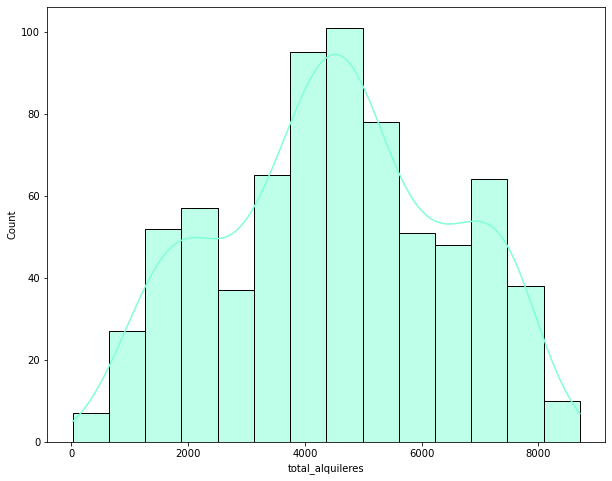

In [115]:
#Variable respuesta modelo I: 'alquiler_casual'

sns.histplot(df["total_alquileres"], kde = True, color = "aquamarine");

In [116]:
stats.shapiro(df["total_alquileres"])

ShapiroResult(statistic=0.9802490472793579, pvalue=2.313480784721378e-08)

Raíz-cuadrada porque tenemos sesgo a la derecha

In [117]:
#Probamos de normalizar 'alquiler_casual' con la raiz cuadrada, ya que está muy sesgada a la izquierda

df["total_alquileres_raiz"] = df["total_alquileres"].apply(lambda x: math.sqrt(x))
df.head(2)

,fecha,estacion,año,mes,festivo,dia_sem,laborable,prevision_tiempo,sensacion_termica,humedad,velocidad_viento,alquiler_casual,alquiler_registrado,total_alquileres,total_alquileres_raiz
0,2018-01-01,Invierno,2018,enero,no_festivo,lunes,0,2,18.18125,80.5833,10.749882,331,654,985,31.384710
1,2018-02-01,Invierno,2018,enero,no_festivo,jueves,0,2,17.68695,69.6087,16.652113,131,670,801,28.301943


In [118]:
#comprobamos con el shapiro si se han normalizado los datos 

stats.shapiro(df["total_alquileres_raiz"])

ShapiroResult(statistic=0.9646831154823303, pvalue=2.879613214545884e-12)

In [119]:
#probamos a normalizar la variable con box-cox

df['total_alquileres_boxcox'], lambda_ajustada = stats.boxcox(df['total_alquileres'])
df.head(2)

,fecha,estacion,año,mes,festivo,dia_sem,laborable,prevision_tiempo,sensacion_termica,humedad,velocidad_viento,alquiler_casual,alquiler_registrado,total_alquileres,total_alquileres_raiz,total_alquileres_boxcox
0,2018-01-01,Invierno,2018,enero,no_festivo,lunes,0,2,18.18125,80.5833,10.749882,331,654,985,31.384710,505.996731
1,2018-02-01,Invierno,2018,enero,no_festivo,jueves,0,2,17.68695,69.6087,16.652113,131,670,801,28.301943,421.088832


In [120]:
stats.shapiro(df["total_alquileres_boxcox"])

ShapiroResult(statistic=0.9801719784736633, pvalue=2.1925126603150602e-08)

Podemos visualizar la diferencia entre los datos normalizados y sin normalizar con un distplot

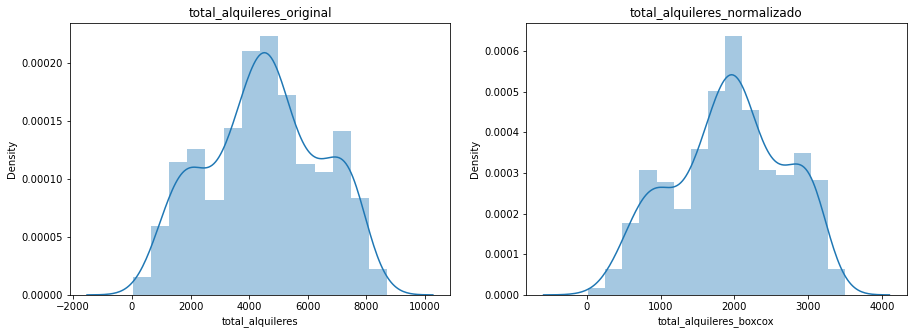

In [121]:
fig, axes = plt.subplots(1, 2, figsize = (15,5))
axes[0].set_title('total_alquileres_original')
axes[1].set_title('total_alquileres_normalizado')
sns.distplot(df["total_alquileres"] ,ax = axes[0])
sns.distplot(df["total_alquileres_boxcox"], ax = axes[1]);

In [122]:
#Nos quedamos con la columna 'alquiler_casual_boxcox'

df.drop(['total_alquileres', 'total_alquileres_raiz'], axis = 1, inplace = True)
df.head()

,fecha,estacion,año,mes,festivo,dia_sem,laborable,prevision_tiempo,sensacion_termica,humedad,velocidad_viento,alquiler_casual,alquiler_registrado,total_alquileres_boxcox
0,2018-01-01,Invierno,2018,enero,no_festivo,lunes,0,2,18.18125,80.5833,10.749882,331,654,505.996731
1,2018-02-01,Invierno,2018,enero,no_festivo,jueves,0,2,17.68695,69.6087,16.652113,131,670,421.088832
2,2018-03-01,Invierno,2018,enero,no_festivo,jueves,1,1,9.47025,43.7273,16.636703,120,1229,668.973918
3,2018-04-01,Primavera,2018,enero,no_festivo,domingo,1,1,10.60610,59.0435,10.739832,108,1454,761.936013
4,2018-05-01,Primavera,2018,enero,no_festivo,martes,1,1,11.46350,43.6957,12.522300,82,1518,778.363548


Con el box-cox los datos se han corregido bastante, pero siguen sin estar normalizados.

Con esta variable decidimos pasar directamente a un Decision Tree

In [123]:
#Lo primero que hacemos es estandarizar las variables numéricas

df_num = df.select_dtypes(include = np.number)


In [124]:
df_num.head(2)

,sensacion_termica,humedad,velocidad_viento,alquiler_casual,alquiler_registrado,total_alquileres_boxcox
0,18.18125,80.5833,10.749882,331,654,505.996731
1,17.68695,69.6087,16.652113,131,670,421.088832


In [125]:
#Iniciamos el método RobustScaler y lo aplicamos
robust = RobustScaler()
robust.fit(df_num)
X_robust = robust.transform(df_num)

In [126]:
numericas_robust = pd.DataFrame(X_robust, columns = df_num.columns)
numericas_robust.head(2)

,sensacion_termica,humedad,velocidad_viento,alquiler_casual,alquiler_registrado,total_alquileres_boxcox
0,-0.456399,0.856714,-0.208909,-0.494713,-1.319816,-1.360362
1,-0.492863,0.332554,0.687550,-0.751041,-1.312801,-1.439459


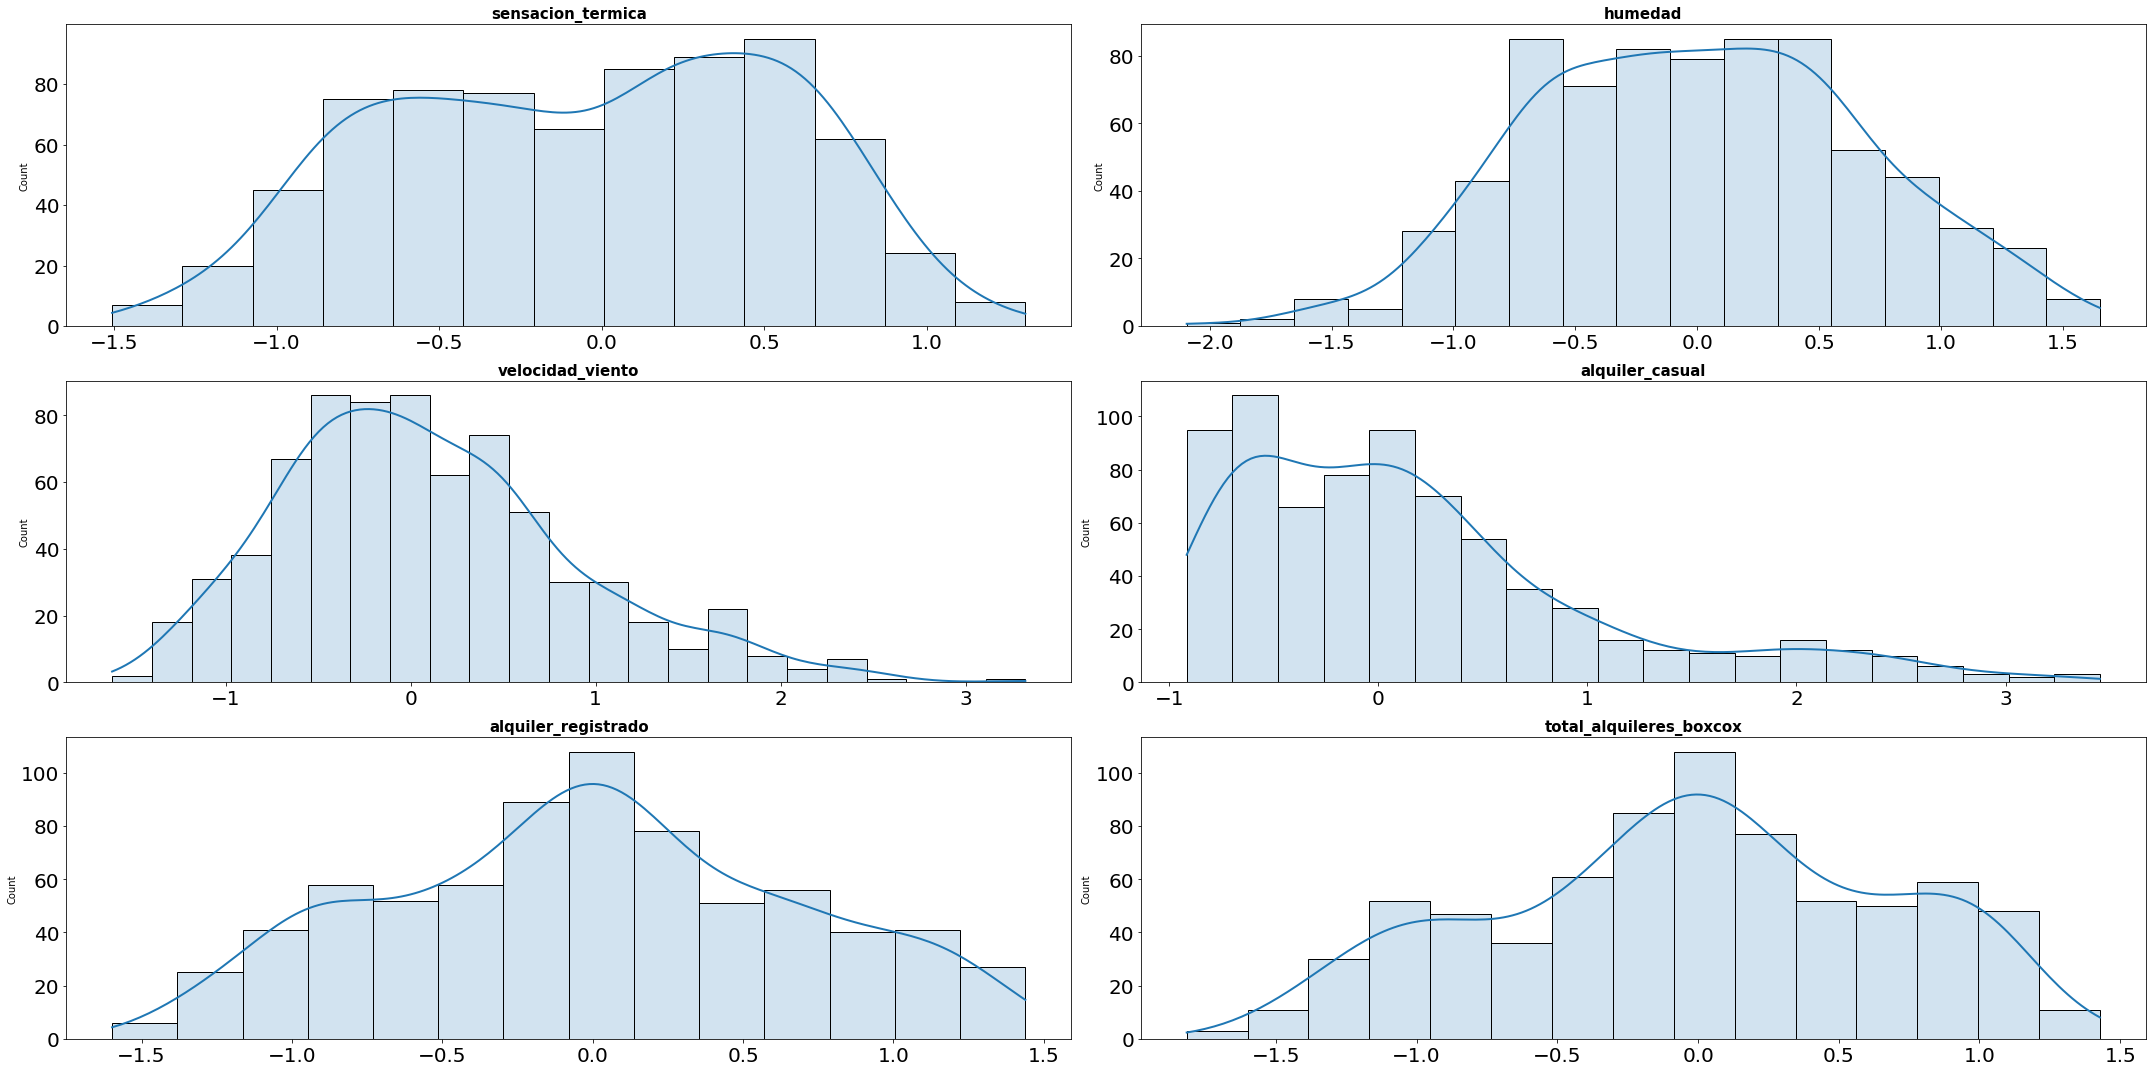

In [127]:
#Visualizamos la distribución de las variables numéricas una vez estandarizadas

fig, axes = plt.subplots(nrows = 3, ncols = 2, figsize = (30, 15))
columnas_robust = numericas_robust.columns
axes = axes.flat

for i, colum in enumerate(columnas_robust):
    sns.histplot(
        data = numericas_robust,
        x = colum,
        kde = True,
        line_kws = {"linewidth": 2},
        alpha = 0.2,
        ax = axes[i])
    axes[i].set_title(colum, fontsize = 15, fontweight = "bold")
    axes[i].tick_params(labelsize = 20)
    axes[i].set_xlabel("")
    
fig.tight_layout();

In [128]:
#Adjuntamos las variables estandarizadas a nuestro dataframe

df_est = df_num[df_num.columns] = numericas_robust
df_est.head(2)


,sensacion_termica,humedad,velocidad_viento,alquiler_casual,alquiler_registrado,total_alquileres_boxcox
0,-0.456399,0.856714,-0.208909,-0.494713,-1.319816,-1.360362
1,-0.492863,0.332554,0.687550,-0.751041,-1.312801,-1.439459


Codificamos las variables categóricas

In [129]:
#Creamos un dataframe sólo con las variables categóricas

df_cat = df.select_dtypes(exclude=np.number).drop('fecha', axis = 1)
df_cat.head(2)

,estacion,año,mes,festivo,dia_sem,laborable,prevision_tiempo
0,Invierno,2018,enero,no_festivo,lunes,0,2
1,Invierno,2018,enero,no_festivo,jueves,0,2


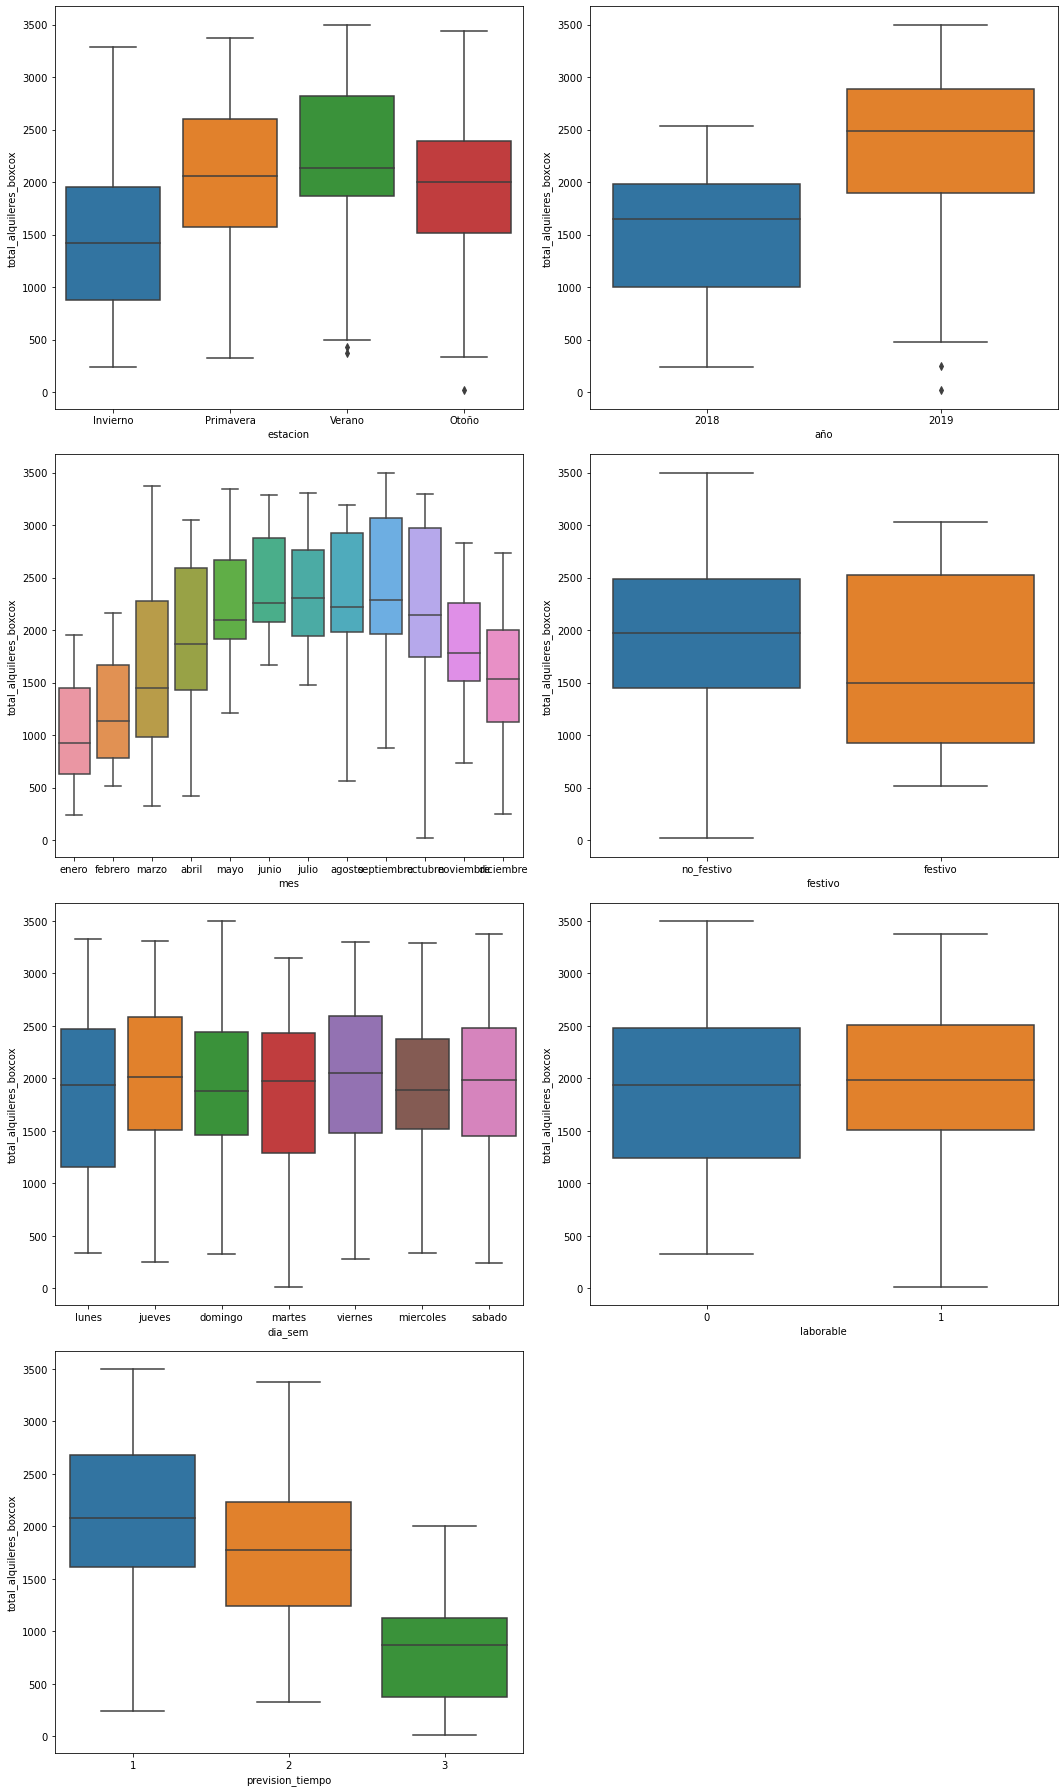

In [130]:
# sacamos boxplots para ver si las variables tienen orden:

fig, axes = plt.subplots(4, 2, figsize=(15, 25))
axes = axes.flat
lista_casual = df_cat.columns
for indice, elemento in enumerate(lista_casual):
    sns.boxplot(x = elemento, y = "total_alquileres_boxcox", data = df, ax=axes[indice])
plt.tight_layout()
plt.delaxes(axes[-1])
plt.show();

Orden de las variables: (tomamos como referencia cada 500 puntos = 1)
 
lista_dict = [{'Invierno': 0, 'Otoño':2, 'Primavera': 2.2, 'Verano': 2.5}, {'2018':0, '2019':1.5}, {'enero':0, 'febrero':0.5, 'diciembre': 1.2, 
                'noviembre': 1.7, 'marzo':1, 'octubre':2, 'abril': 1.7, 'mayo': 2, 'junio':2.5, 'julio':2.6, 'septiembre':2.6, 'agosto':2.5}, {"festivo":0, "no_festivo":1},
                {3:0, 2:1.5, 1:2}]


In [131]:
#Lo primero que tenemos que hacer es resetear los índices de df, ya que hemos eliminado algunos registros

df = df.reset_index(drop= True)

In [132]:
#creamos los diccionarios con el orden que queremos establecer
lista_dict = [{'Invierno': 0, 'Otoño':2, 'Primavera': 2.2, 'Verano': 2.5}, {'2018':0, '2019':1.5}, {'enero':0, 'febrero':0.5, 'diciembre': 1.2, 
                'noviembre': 1.7, 'marzo':1, 'octubre':2, 'abril': 1.7, 'mayo': 2, 'junio':2.5, 'julio':2.6, 'septiembre':2.6, 'agosto':2.5}, {"festivo":0, "no_festivo":1},
                {3:0, 2:1.5, 1:2}]

#creamos una lista con las columnas que tienen orden
lista_col = df_cat.columns.drop(['dia_sem', 'laborable'])


In [133]:
#Usamos map para codificar las columnas que tienen orden
#creamos un dataframe vacío para ir añadiendo las columnas codificadas
df_enco = pd.DataFrame()

for dic, col in zip(lista_dict, lista_col):   
    
    df_enco[f'{col}_map'] = df[col].map(dic)
    
df_enco.head(2)

,estacion_map,año_map,mes_map,festivo_map,prevision_tiempo_map
0,0.0,0.0,0.0,1,1.5
1,0.0,0.0,0.0,1,1.5


In [134]:
for col in df_enco.columns:
    print(df_enco[col].unique())
    print('-------------------------')

[0.  2.2 2.5 2. ]
-------------------------
[0.  1.5]
-------------------------
[0.  0.5 1.  1.7 2.  2.5 2.6 1.2]
-------------------------
[1 0]
-------------------------
[1.5, 2.0, 0.0]
Categories (3, float64): [2.0, 1.5, 0.0]
-------------------------


In [135]:
#unimos los dataframes de las variables numéricas estandarizadas con el dataframe de las variables categóricas codificadas

df_estenc = pd.concat([numericas_robust, df_enco], axis=1)
df_estenc.head()

,sensacion_termica,humedad,velocidad_viento,alquiler_casual,alquiler_registrado,total_alquileres_boxcox,estacion_map,año_map,mes_map,festivo_map,prevision_tiempo_map
0,-0.456399,0.856714,-0.208909,-0.494713,-1.319816,-1.360362,0.0,0.0,0.0,1,1.5
1,-0.492863,0.332554,0.687550,-0.751041,-1.312801,-1.439459,0.0,0.0,0.0,1,1.5
2,-1.098990,-0.903573,0.685210,-0.765139,-1.067733,-1.208539,0.0,0.0,0.0,1,2.0
3,-1.015201,-0.172053,-0.210435,-0.780519,-0.969093,-1.121939,2.2,0.0,0.0,1,2.0
4,-0.951952,-0.905082,0.060294,-0.813842,-0.941035,-1.106635,2.2,0.0,0.0,1,2.0


In [136]:
#guardamos el dataframe

df_estenc.to_csv('../data/df_total_estand_encod.csv')

Decision Tree:

In [137]:
# dividimos en dos dataframes: x(predictoras) e y (variable respuesta)
# creamos los 4 grupos (train-test)
 
x= df_estenc.drop("total_alquileres_boxcox", axis= 1)
y = df_estenc["total_alquileres_boxcox"]

x_train_total, x_test_total, y_train_total, y_test_total = train_test_split(x, y, test_size = 0.2, random_state = 42)

In [138]:
# instanciamos el método y lo ajustamos:

arbol_total = DecisionTreeRegressor(random_state =0)
arbol_total.fit(x_train_total, y_train_total)

DecisionTreeRegressor(random_state=0)

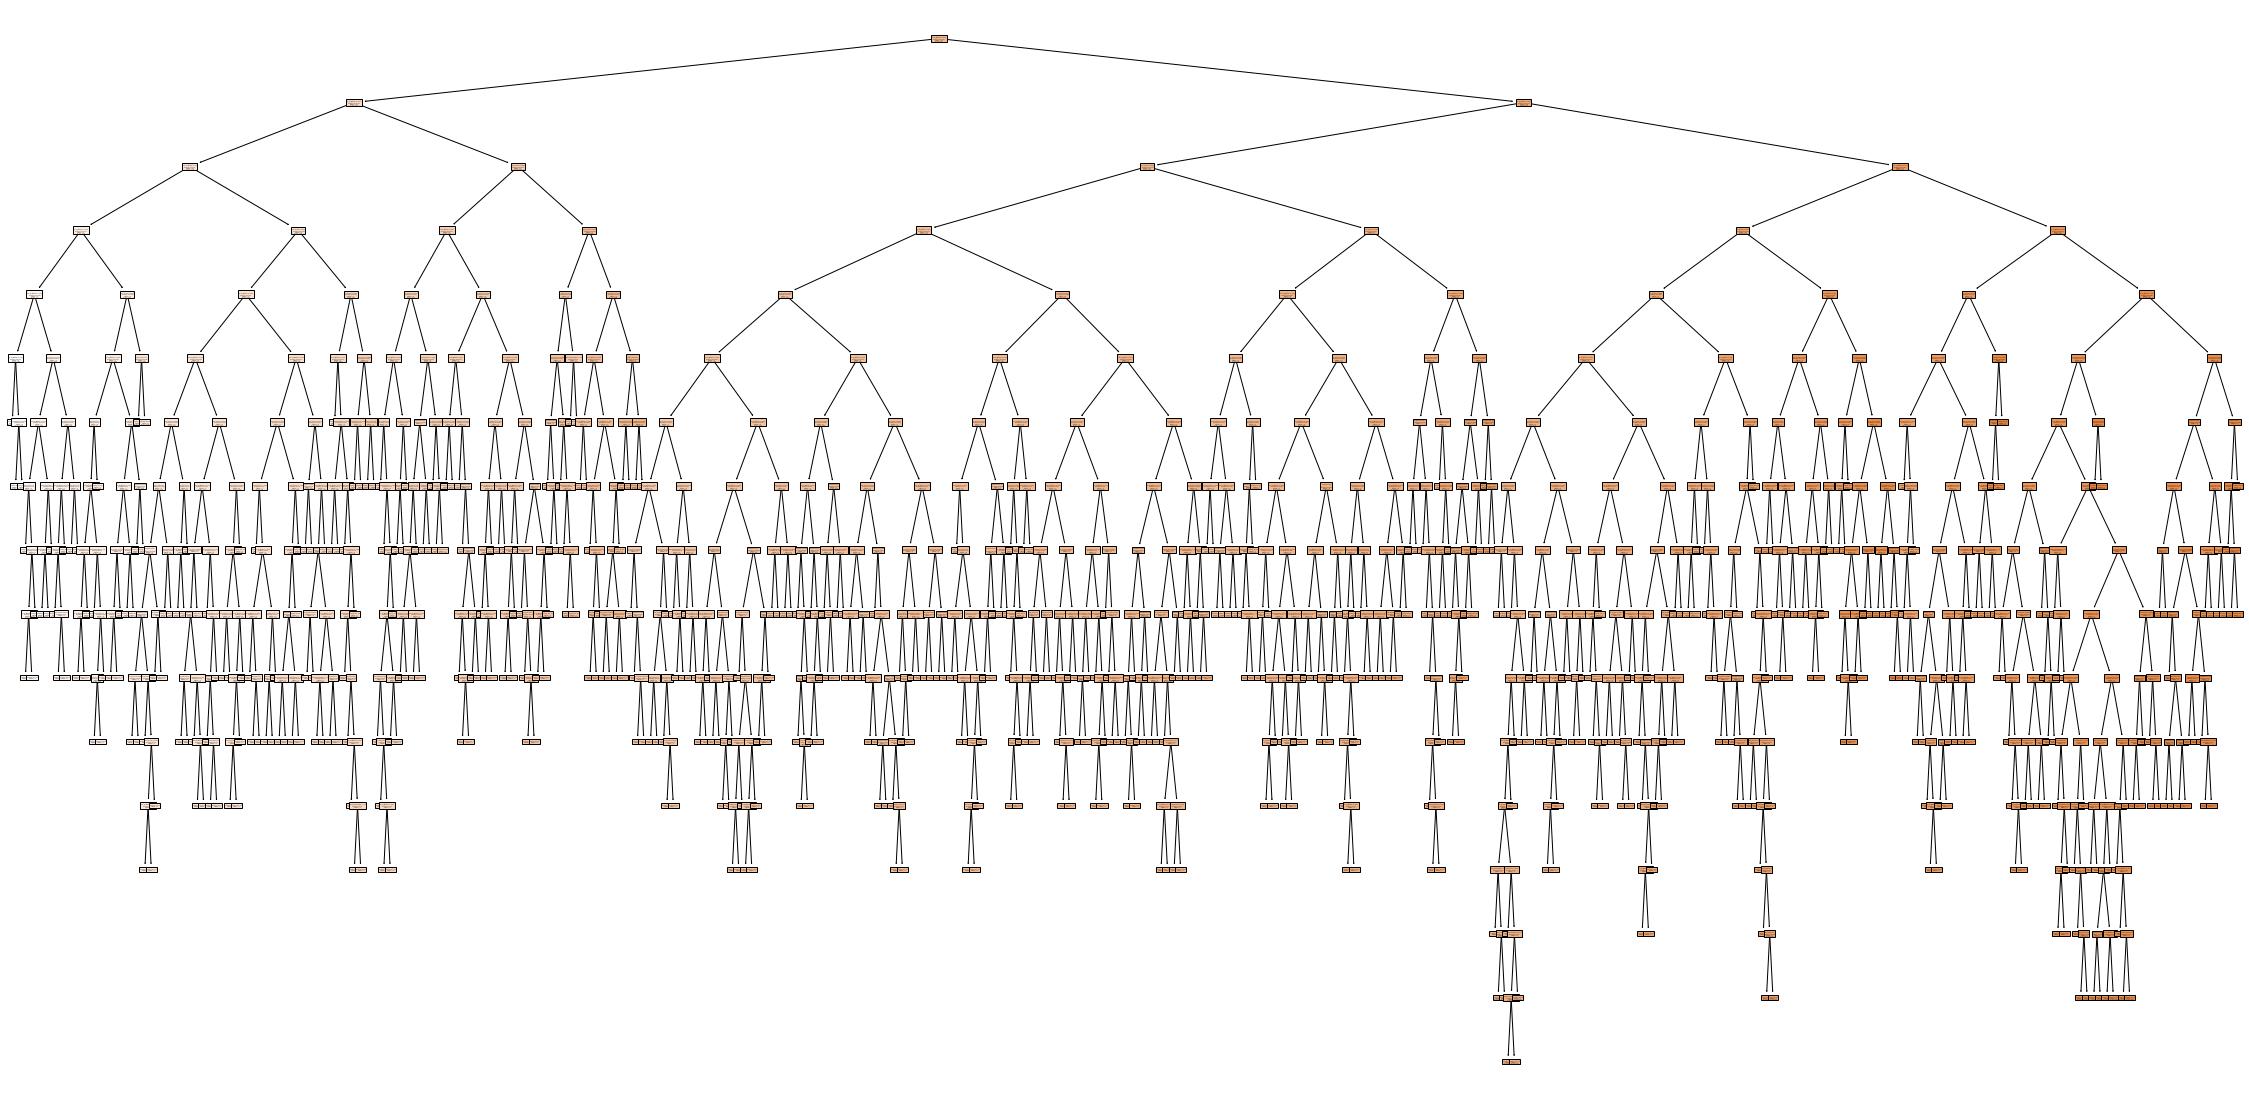

In [139]:
# imprimimos:

fig = plt.figure(figsize = (40, 20))
tree.plot_tree(arbol_total, feature_names = list(x_train_total.columns), filled = True);

In [140]:
# calculamos la profundidad y la raíz cuadrada de las variables:

print(arbol_total.tree_.max_depth)
print("___________")
max_features = np.sqrt(len(x_train_total.columns))
max_features

16
___________


3.1622776601683795

In [141]:
y_pred_test_total = arbol_total.predict(x_test_total)
y_pred_train_total = arbol_total.predict(x_train_total)

In [142]:
def metricas(y_test, y_train, y_test_pred, y_train_pred, tipo_modelo):
    """con esta función calculamos las métricas del árbol

    Args:
        y_test: datos test
        y_train: datos para entrenar
        y_test_pred: datos predichos predictoras (test)
        y_train_pred: datos predichos predictoras (entrenamiento)
        tipo_modelo: nombre que le queremos dar a nuestro modelo

    Returns:
        df: dataframe con las métricas
    """
    resultados = {'MAE': [mean_absolute_error(y_test, y_test_pred), mean_absolute_error(y_train, y_train_pred)],
                'MSE': [mean_squared_error(y_test, y_test_pred), mean_squared_error(y_train, y_train_pred)],
                'RMSE': [np.sqrt(mean_squared_error(y_test, y_test_pred)), np.sqrt(mean_squared_error(y_train, y_train_pred))],
                'R2':  [r2_score(y_test, y_test_pred), r2_score(y_train, y_train_pred)],
                 "set": ["test", "train"]}
    df = pd.DataFrame(resultados)
    df["modelo"] = tipo_modelo
    return df

In [143]:
arbol_total_resultado = metricas(y_test_total, y_train_total, y_pred_test_total, y_pred_train_total, "DT Total I")
arbol_total_resultado

,MAE,MSE,RMSE,R2,set,modelo
0,0.044162,0.003682,0.060677,0.991721,test,DT Total I
1,0.000000,0.000000,0.000000,1.000000,train,DT Total I


In [144]:
param_total = {"max_depth": [6,8,10], 
        "max_features": [1,2,3,4],
        "min_samples_split": [10, 50, 100],
        "min_samples_leaf": [10,50, 100]}

In [145]:
gs_total = GridSearchCV(
            estimator=DecisionTreeRegressor(), 
            param_grid= param_total, 
            cv=10, 
            verbose= 0,
            return_train_score = True, 
            scoring="neg_mean_squared_error") 

gs_total.fit(x_train_total, y_train_total)

GridSearchCV(cv=10, estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': [6, 8, 10], 'max_features': [1, 2, 3, 4],
                         'min_samples_leaf': [10, 50, 100],
                         'min_samples_split': [10, 50, 100]},
             return_train_score=True, scoring='neg_mean_squared_error')

In [146]:
mejor_modelo_total = gs_total.best_estimator_
mejor_modelo_total

DecisionTreeRegressor(max_depth=6, max_features=4, min_samples_leaf=10,
                      min_samples_split=10)

In [147]:
y_pred_test_total_2 = mejor_modelo_total.predict(x_test_total)
y_pred_train_total_2 = mejor_modelo_total.predict(x_train_total)

In [148]:
arbol_total_resultado_2 = metricas(y_test_total, y_train_total, y_pred_test_total_2, y_pred_train_total_2, "DT Total II")
arbol_total_resultado_2

,MAE,MSE,RMSE,R2,set,modelo
0,0.156964,0.047326,0.217546,0.893578,test,DT Total II
1,0.130581,0.030801,0.175502,0.938544,train,DT Total II


In [149]:
param_total = {"max_depth": [12,14,16], 
        "max_features": [2,3,4],
        "min_samples_split": [10,20],
        "min_samples_leaf": [10,20]}

In [150]:
gs_total = GridSearchCV(
            estimator=DecisionTreeRegressor(), 
            param_grid= param_total, 
            cv=10,
            verbose= 0,
            return_train_score = True, 
            scoring="neg_mean_squared_error") 

gs_total.fit(x_train_total, y_train_total)

GridSearchCV(cv=10, estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': [12, 14, 16], 'max_features': [2, 3, 4],
                         'min_samples_leaf': [10, 20],
                         'min_samples_split': [10, 20]},
             return_train_score=True, scoring='neg_mean_squared_error')

In [151]:
y_pred_test_total_3 = mejor_modelo_total.predict(x_test_total)
y_pred_train_total_3 = mejor_modelo_total.predict(x_train_total)

In [152]:
arbol_total_resultado_3 = metricas(y_test_total, y_train_total, y_pred_test_total_3, y_pred_train_total_3, "DT total III")
arbol_total_resultado_3

,MAE,MSE,RMSE,R2,set,modelo
0,0.156964,0.047326,0.217546,0.893578,test,DT total III
1,0.130581,0.030801,0.175502,0.938544,train,DT total III


In [153]:
dt_resultados_total = pd.concat([arbol_total_resultado, arbol_total_resultado_2, arbol_total_resultado_3], axis = 0)
dt_resultados_total

,MAE,MSE,RMSE,R2,set,modelo
0,0.044162,0.003682,0.060677,0.991721,test,DT Total I
1,0.000000,0.000000,0.000000,1.000000,train,DT Total I
0,0.156964,0.047326,0.217546,0.893578,test,DT Total II
1,0.130581,0.030801,0.175502,0.938544,train,DT Total II
0,0.156964,0.047326,0.217546,0.893578,test,DT total III
1,0.130581,0.030801,0.175502,0.938544,train,DT total III


Creamos un Random Forest:

Como ya tenemos creadas las variables, vamos directamente a crear el bosque

In [154]:
param_rf_total = {"max_depth": [11, 12],
        "max_features": [7, 8],
        "min_samples_split": [11, 12],
        "min_samples_leaf": [56, 57],
        "n_estimators": [100]}

gs_rf_total = GridSearchCV(
            estimator=RandomForestRegressor(n_estimators=100), 
            param_grid= param_rf_total,
            cv=10,
            verbose=0, 
            return_train_score = True,
            scoring="neg_mean_squared_error") 

gs_rf_total.fit(x_train_total, y_train_total)

GridSearchCV(cv=10, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [11, 12], 'max_features': [7, 8],
                         'min_samples_leaf': [56, 57],
                         'min_samples_split': [11, 12], 'n_estimators': [100]},
             return_train_score=True, scoring='neg_mean_squared_error')

In [155]:
bosque_total = gs_rf_total.best_estimator_
bosque_total

RandomForestRegressor(max_depth=11, max_features=7, min_samples_leaf=56,
                      min_samples_split=11)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]


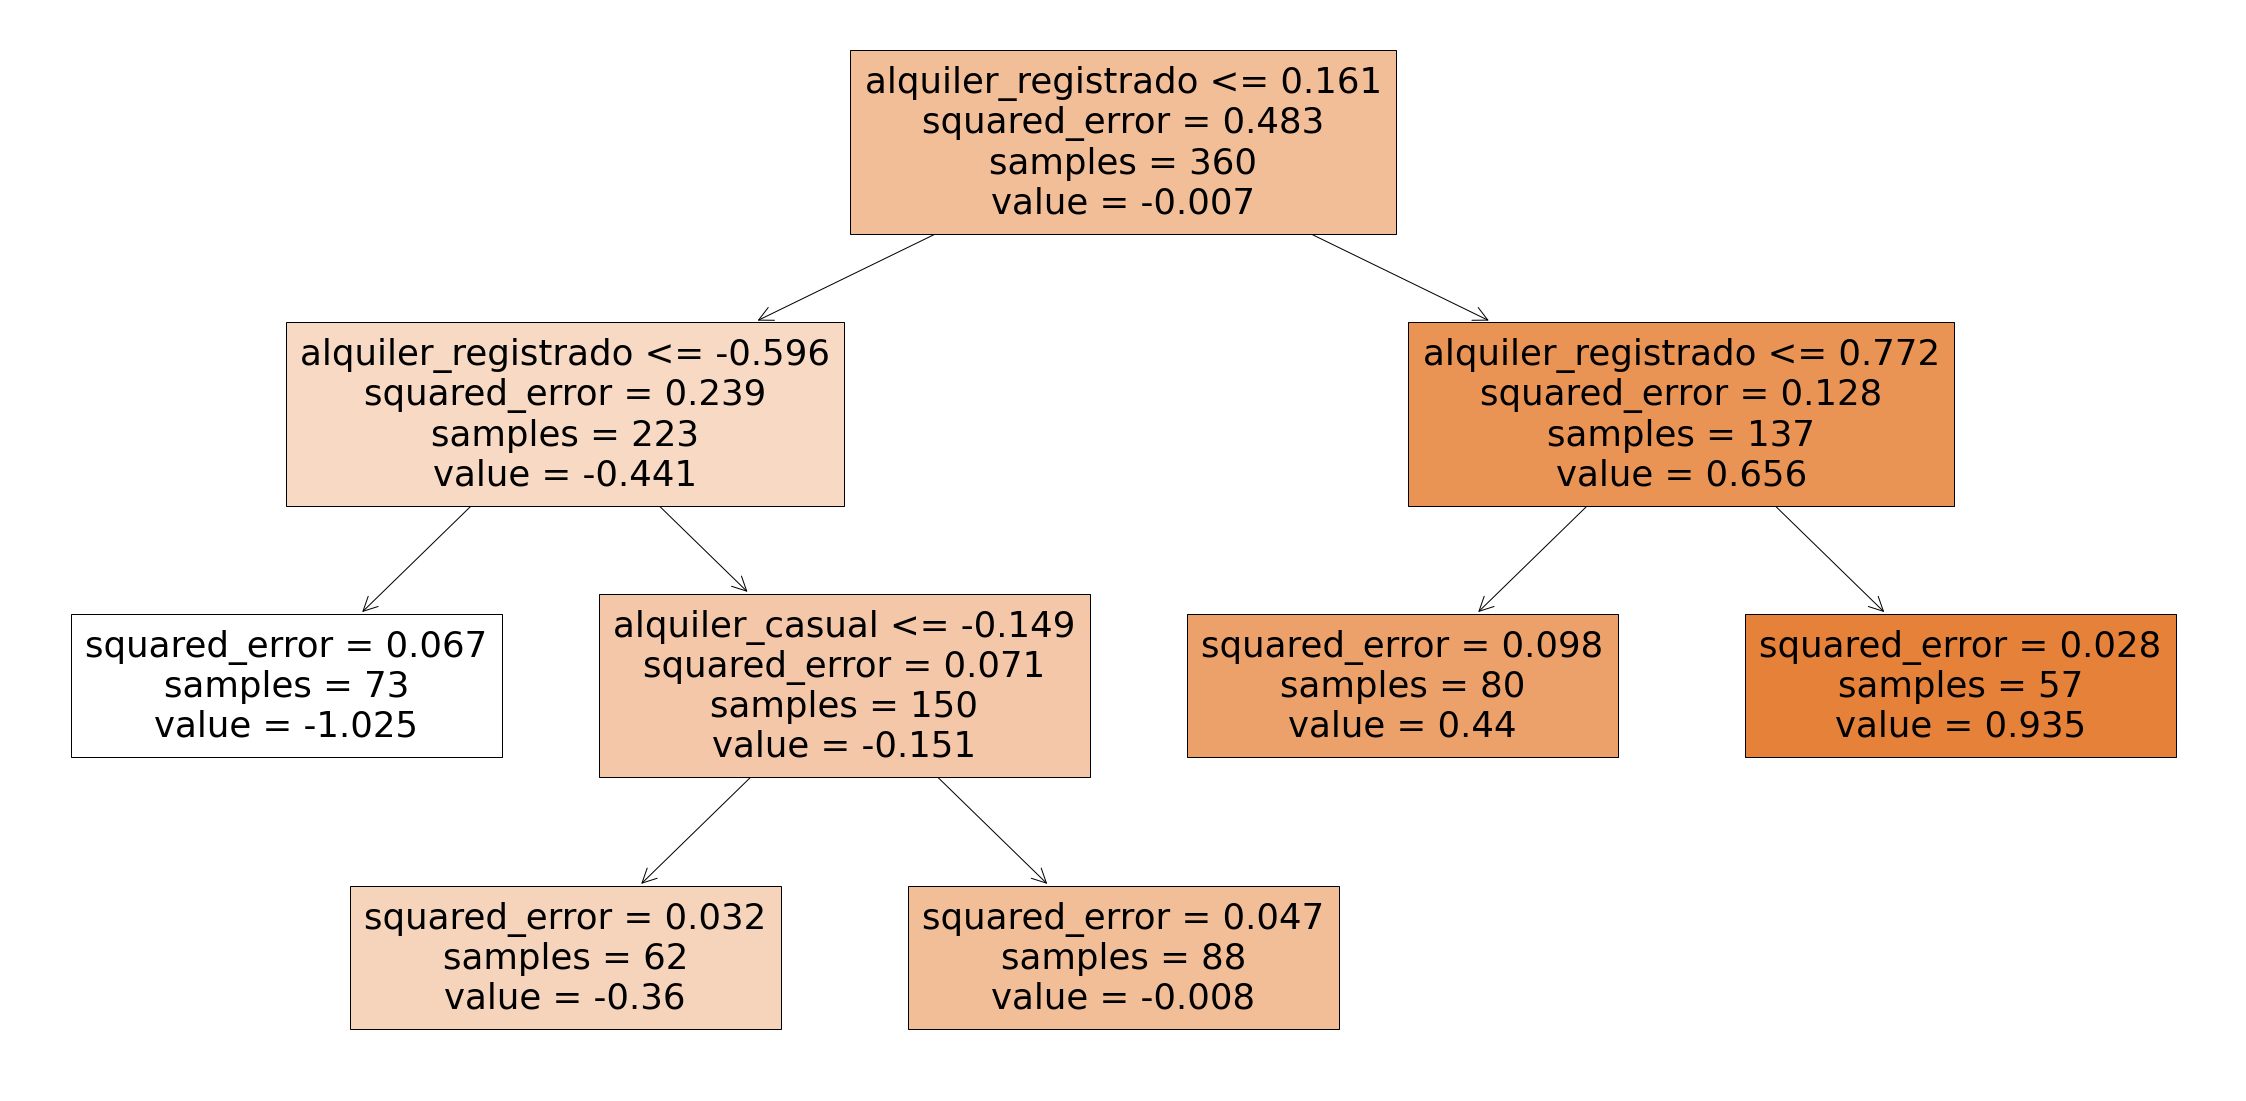

In [156]:
for arbol in tqdm(bosque_total):
    fig = plt.figure(figsize=(40, 20))
    tree.plot_tree(arbol, feature_names= list(x_train_total.columns), filled = True)
    plt.savefig("../graficas/random_forest_total.png");
    break

In [157]:
y_pred_test_rf = bosque_total.predict(x_test_total)
y_pred_train_rf = bosque_total.predict(x_train_total)

results_forest_total = metricas(y_test_total, y_train_total, y_pred_test_rf, y_pred_train_rf, "RF total I")
results_forest_total

,MAE,MSE,RMSE,R2,set,modelo
0,0.101117,0.022498,0.149993,0.949409,test,RF total I
1,0.129488,0.032724,0.180898,0.934707,train,RF total I


In [178]:
param_rf_total = {"max_depth": [20],
        "max_features": [8,9],
        "min_samples_split": [11, 12],
        "min_samples_leaf": [56, 57],
        "n_estimators": [100]}

gs_rf_total = GridSearchCV(
            estimator=RandomForestRegressor(n_estimators=100), 
            param_grid= param_rf_total,
            cv=10,
            verbose=0, 
            return_train_score = True,
            scoring="neg_mean_squared_error") 

gs_rf_total.fit(x_train_total, y_train_total)
bosque_total = gs_rf_total.best_estimator_
bosque_total

RandomForestRegressor(max_depth=20, max_features=8, min_samples_leaf=56,
                      min_samples_split=11)

In [179]:
y_pred_test_rf_2 = bosque_total.predict(x_test_total)
y_pred_train_rf_2 = bosque_total.predict(x_train_total)

results_forest_total_2 = metricas(y_test_total, y_train_total, y_pred_test_rf_2, y_pred_train_rf_2, "RF total II")
results_forest_total_2

,MAE,MSE,RMSE,R2,set,modelo
0,0.107448,0.024720,0.157225,0.944413,test,RF total II
1,0.134489,0.033913,0.184154,0.932336,train,RF total II


In [180]:
param_rf_total = {"max_depth": [4,6],
        "max_features": [4],
        "min_samples_split": [11, 12],
        "min_samples_leaf": [56, 57],
        "n_estimators": [100]}

gs_rf_total = GridSearchCV(
            estimator=RandomForestRegressor(n_estimators=100), 
            param_grid= param_rf_total,
            cv=10,
            verbose=0, 
            return_train_score = True,
            scoring="neg_mean_squared_error") 

gs_rf_total.fit(x_train_total, y_train_total)
bosque_total = gs_rf_total.best_estimator_
bosque_total

RandomForestRegressor(max_depth=4, max_features=4, min_samples_leaf=56,
                      min_samples_split=11)

In [181]:
y_pred_test_rf_3 = bosque_total.predict(x_test_total)
y_pred_train_rf_3 = bosque_total.predict(x_train_total)

results_forest_total_3 = metricas(y_test_total, y_train_total, y_pred_test_rf_3, y_pred_train_rf_3, "RF total III")
results_forest_total_3

,MAE,MSE,RMSE,R2,set,modelo
0,0.130545,0.031145,0.176479,0.929965,test,RF total III
1,0.156119,0.047449,0.217828,0.905327,train,RF total III


In [182]:
rf_resultados_total = pd.concat([results_forest_total, results_forest_total_2, results_forest_total_3], axis = 0)
rf_resultados_total

,MAE,MSE,RMSE,R2,set,modelo
0,0.101117,0.022498,0.149993,0.949409,test,RF total I
1,0.129488,0.032724,0.180898,0.934707,train,RF total I
0,0.107448,0.024720,0.157225,0.944413,test,RF total II
1,0.134489,0.033913,0.184154,0.932336,train,RF total II
0,0.130545,0.031145,0.176479,0.929965,test,RF total III
1,0.156119,0.047449,0.217828,0.905327,train,RF total III


In [183]:
resultados_total_alquileres = pd.concat([dt_resultados_total,rf_resultados_total], axis= 0)
resultados_total_alquileres.to_csv("../data/resultados_total_alquileres.csv")

In [184]:
resultados_total_alquileres

,MAE,MSE,RMSE,R2,set,modelo
0,0.044162,0.003682,0.060677,0.991721,test,DT Total I
1,0.000000,0.000000,0.000000,1.000000,train,DT Total I
0,0.156964,0.047326,0.217546,0.893578,test,DT Total II
1,0.130581,0.030801,0.175502,0.938544,train,DT Total II
0,0.156964,0.047326,0.217546,0.893578,test,DT total III
1,0.130581,0.030801,0.175502,0.938544,train,DT total III
0,0.101117,0.022498,0.149993,0.949409,test,RF total I
1,0.129488,0.032724,0.180898,0.934707,train,RF total I
0,0.107448,0.024720,0.157225,0.944413,test,RF total II
1,0.134489,0.033913,0.184154,0.932336,train,RF total II


# CONCLUSIONES:

- El primero Decission Tree queda descartado por overfitting.

- El resto de modelos tienen éxito los Random Forest, en cuanto a que los resultados del test son mejores que los del train. Elegimos el RF III ya que es en el que se ha conseguido alejarse más del overfitting.

In [186]:
importancia_predictores = pd.DataFrame(
                            {'predictor': x_train_total.columns,
                             'importancia': mejor_modelo_total.feature_importances_}
                            )
# ordenamos de mayor a menor los resultados
importancia_predictores.sort_values(by=["importancia"], ascending=False, inplace = True)
# printeamos los resultados
print("Importancia de los predictores en el modelo")
print("-------------------------------------------")
importancia_predictores

Importancia de los predictores en el modelo
-------------------------------------------


,predictor,importancia
4,alquiler_registrado,0.384446
7,mes_map,0.326155
3,alquiler_casual,0.239183
6,año_map,0.025396
0,sensacion_termica,0.021243
2,velocidad_viento,0.002660
1,humedad,0.000917
5,estacion_map,0.000000
8,festivo_map,0.000000
9,prevision_tiempo_map,0.000000


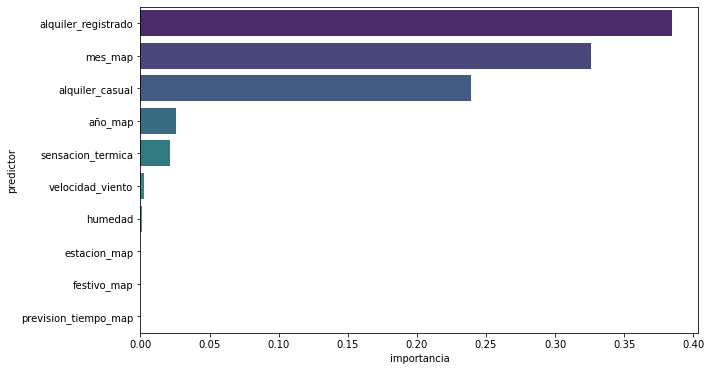

In [187]:
# por último ploteamos los resultados para verlo de una forma más amigable.
plt.figure(figsize=(10,6))
sns.barplot(x = "importancia", y = "predictor", data = importancia_predictores, palette="viridis");
plt.show()

In [188]:
#Vamos a revertir los valores de RMSE para ver la diferencia entre los alquileres reales y los predichos

datos_est = resultados_total_alquileres['RMSE'] #esta es la columna RMSE

# Aplicamos el método inverso de Box-Cox
if lambda_ajustada == 0: #esta es la lambda que nos dio al aplicar el box-cox
    datos_destransformados = np.exp(datos_est)
else:
    datos_destransformados = (lambda_ajustada * datos_est + 1) ** (1 / lambda_ajustada)


In [189]:
#Añadimos los datos desestandarizados al dataframe de métricas

resultados_total_alquileres['RMSE_unit'] = datos_destransformados
resultados_total_alquileres

,MAE,MSE,RMSE,R2,set,modelo,RMSE_unit
0,0.044162,0.003682,0.060677,0.991721,test,DT Total I,1.060883
1,0.000000,0.000000,0.000000,1.000000,train,DT Total I,1.000000
0,0.156964,0.047326,0.217546,0.893578,test,DT Total II,1.220101
1,0.130581,0.030801,0.175502,0.938544,train,DT Total II,1.177182
0,0.156964,0.047326,0.217546,0.893578,test,DT total III,1.220101
1,0.130581,0.030801,0.175502,0.938544,train,DT total III,1.177182
0,0.101117,0.022498,0.149993,0.949409,test,RF total I,1.151227
1,0.129488,0.032724,0.180898,0.934707,train,RF total I,1.182680
0,0.107448,0.024720,0.157225,0.944413,test,RF total II,1.158579
1,0.134489,0.033913,0.184154,0.932336,train,RF total II,1.185999
